# Youtube comments exploration and pre-processing

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import torch
from transformers import CamembertTokenizer, AutoTokenizer, AutoModelForSequenceClassification
from transformers import CamembertModel, CamembertForSequenceClassification
from torch.utils.data import DataLoader, Dataset



### 1. Combine all the csv files into one 

In [16]:
# Step 1: Get a list of all CSV files in the directory
csv_files = glob.glob('comments_data/*.csv')

# Step 2: Initialize an empty list to store DataFrames
dataframes = []

# Step 3: Read each CSV file into a DataFrame and append to the list
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Step 4: Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Step 5: Save the combined DataFrame to a new CSV file
combined_df.to_csv('comments_data/combined_data.csv', index=False)

print("CSV files have been successfully merged into 'combined_file.csv'.")

CSV files have been successfully merged into 'combined_file.csv'.


### 2. Dealing with the duplicates

##### Identify if there are duplicates and store them in duplicate_comments.csv

In [26]:
# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('comments_data/combined_data.csv')

print(f'Number of comments in comments_combined: {df.shape}')

# Step 2: Identify duplicate comments
duplicates = df[df.duplicated(subset=['Timestamp', 'Username', 'VideoID', 'Comment'], keep=False)]

print(f'Number of duplicates in comments_combined : {duplicates.shape}')

# Step 3: Output the results
if not duplicates.empty:
    print("Duplicate comments found:")
    print(duplicates)
else:
    print("No duplicate comments found.")

# Save the duplicate comments to a new CSV file to verify manually
if not duplicates.empty:
    duplicates.to_csv('duplicate_comments.csv', index=False)
    print("Duplicate comments have been saved to 'duplicate_comments.csv'.")

Number of comments in comments_combined: (72582, 5)
Number of duplicates in comments_combined : (0, 5)
No duplicate comments found.


##### Remove all the duplicates

In [ ]:
# If there are multiple times the same message

df_cleaned = df.drop_duplicates(subset=['Timestamp', 'Username', 'VideoID', 'Comment'], keep='first')

print(f'Number of comments of df_cleaned: {df_cleaned.shape}')

duplicates_cleaned = df_cleaned[df_cleaned.duplicated(subset=['Timestamp', 'Username', 'VideoID', 'Comment'], keep=False)]

if not duplicates_cleaned.empty:
    print("Duplicate comments found:")
    print(duplicates)
else:
    print("No duplicate comments found.")

# Save the duplicate comments to a new CSV file to verify them manually
if not duplicates_cleaned.empty:
    duplicates.to_csv('duplicate_comments.csv', index=False)
    print("Duplicate comments have been saved to 'duplicate_comments.csv'.")

Number of comments : (72582, 5)
No duplicate comments found.


##### Save the cleaned dataframe to the comments_data/combined_data.csv

In [ ]:
# Update the csv file 

df_cleaned.to_csv('comments_data/combined_data.csv', index=False)

print("The content of 'comment_data/combined_data.csv' has been overwritten with the new DataFrame.")

The content of 'your_file.csv' has been overwritten with the new DataFrame.


##### Verify that we correctly updated combined_data.csv 

In [ ]:
# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('comments_data/combined_data.csv')

print(f'Number of comments in comments_combined: {df.shape}') # Should be equal to df_cleaned.shape

# Step 2: Identify duplicate comments
duplicates = df[df.duplicated(subset=['Timestamp', 'Username', 'VideoID', 'Comment'], keep=False)]

# Step 3: Output the results
if not duplicates.empty:
    print("Duplicate comments found:")
    print(duplicates)
else:
    print("No duplicate comments found.")

# Save the duplicate comments to a new CSV file to observe them manually
if not duplicates.empty:
    duplicates.to_csv('duplicate_comments.csv', index=False)
    print("Duplicate comments have been saved to 'duplicate_comments.csv'.")

No duplicate comments found.


### 3. Preparing the data to be passed unto the model 

In [33]:
# Check the types of elements in the 'Comment' column
non_string_elements = df[~df['Comment'].apply(isinstance, args=(str,))]

# Print the rows with non-string elements
print(non_string_elements.shape)

(64, 5)


In [ ]:
def preprocess_text(text):
    # Ensure the input is a string; replace NaN or non-string types with an empty string. Only if the number of Nan message is small.
    if not isinstance(text, str):
        text = ''  # Handle NaN or non-string cases
    text = text.lower()  # Convert in lower case
    text = re.sub(r'[^a-zA-Zà-ÿ\s]', '', text)  # Suppress the special characters
    return text

# df contains the comments_data file without the duplicates (run previous python)

df['Processed_comment'] = df['Comment'].apply(preprocess_text)



In [69]:
print(df['Processed_comment'].iloc[4455])
print(df['Processed_comment'].size)

bonjour tonton  rsr sil te plaît 
jai alimenté le bot futures il y a plusieurs semaines et il ny a toujours pas eu de trade passé attendezvous la rentrée pour commencer à passer ces trades  estil plus optimal dalimenter les bots spot en attendant  merci pour ton retour et pour tes analyses toujours enrichissantes 
72582


### 4. Transformer and model use

##### Import the fined-tuned model 

In [48]:
save_path = r'C:\Users\matth\Documents\Project\fine_tuned_camembert'

# Charger le tokenizer
tokenizer = CamembertTokenizer.from_pretrained(save_path)

# Charger le modèle fine-tuné
model = CamembertForSequenceClassification.from_pretrained(save_path)

In [70]:
# Example list of preprocessed comments
text1 = []

for i in range(df['Processed_comment'].size):
    text1.append(df['Processed_comment'].iloc[i])

# Initialize lists to store results
all_logits = []
all_probabilities = []
all_predictions = []

# Loop through each text individually
for text in text1:
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract logits
    logits = outputs.logits
    
    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    
    # Predicted class
    predicted_class = torch.argmax(probabilities, dim=-1)
    
    # Store results
    all_logits.append(logits)
    all_probabilities.append(probabilities)
    all_predictions.append(predicted_class.item())

# Print results for all texts
# for i, text in enumerate(text1):
#     print(f"Text: {text}")
#     print(f"Logits: {all_logits[i]}")
#     print(f"Probabilities: {all_probabilities[i]}")
#     print(f"Predicted class: {all_predictions[i]}")
#     print("-" * 30)


In [71]:
df['label'] = all_predictions

In [72]:
df.to_csv('comments_data/labeled_data.csv', index=False)
print("Duplicate comments have been saved to 'duplicate_comments.csv'.")

Duplicate comments have been saved to 'duplicate_comments.csv'.


### Observe the evolution of the number of comments accross time 

In [9]:
# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('comments_data\combined_data.csv')

# Step 2: Convert the 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Step 3: Extract the date (only the day) from the 'Timestamp'
df['Date'] = df['Timestamp'].dt.date

# Step 4: Group by 'VideoID' and get the first 'Date' and count of comments
grouped = df.groupby('VideoID').agg(FirstDate=('Date', 'first'), CommentCount=('Comment', 'count')).reset_index()

# Step 5: Sort the DataFrame by 'FirstDate'
grouped = grouped.sort_values(by='FirstDate')



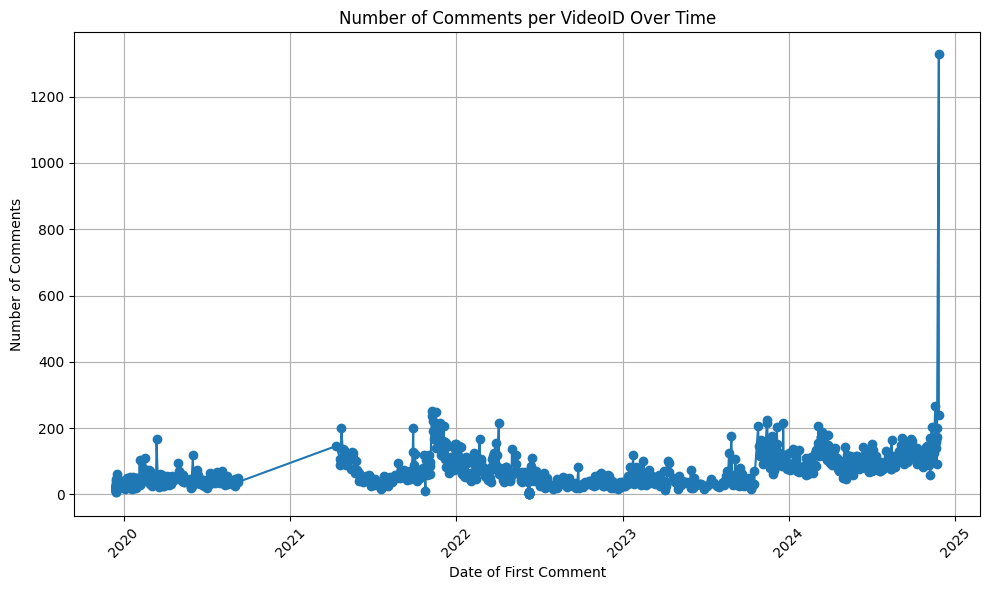

In [10]:
# Step 6: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(grouped['FirstDate'], grouped['CommentCount'], marker='o', linestyle='-')
plt.xlabel('Date of First Comment')
plt.ylabel('Number of Comments')
plt.title('Number of Comments per VideoID Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot the average of the last 7 days 

C:\Users\matth\AppData\Local\Temp\ipykernel_20932\4173683579.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_comments['7DayAvg'] = daily_comments['7DayAvg'].fillna(method='ffill')


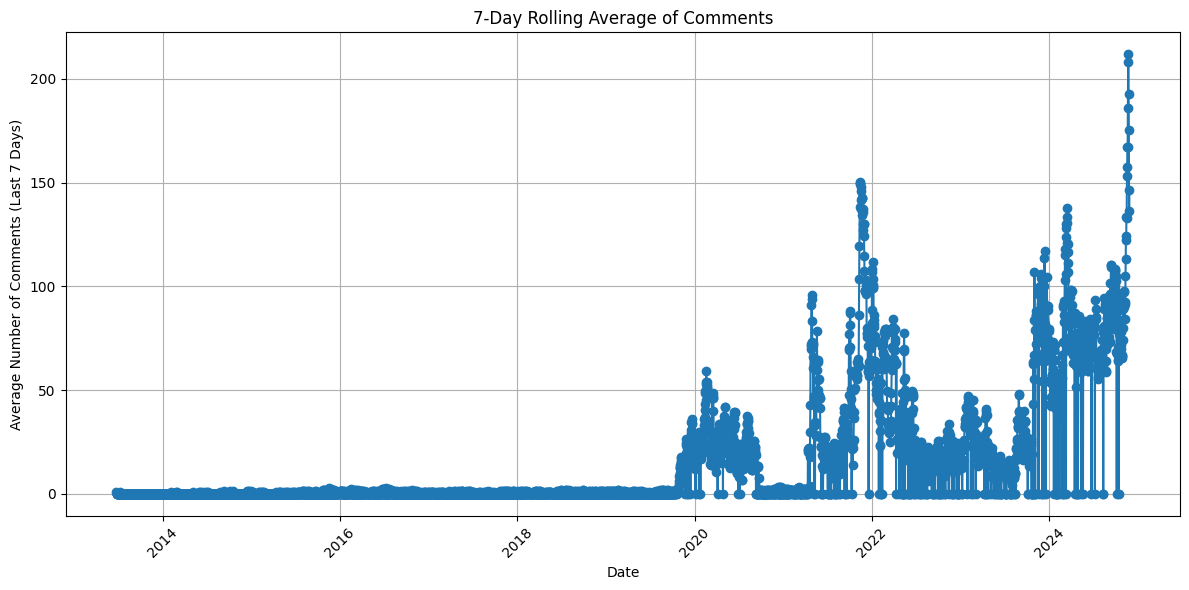

In [ ]:
# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('comments_data/combined_data.csv')

# Step 2: Convert the 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Step 3: Extract the date (only the day) from the 'Timestamp'
df['Date'] = df['Timestamp'].dt.date

# Step 4: Group by 'Date' and count the number of comments
daily_comments = df.groupby('Date').size().reset_index(name='CommentCount')

# Step 5: Set the 'Date' column as the index
daily_comments.set_index('Date', inplace=True)

# Step 6: Calculate the rolling average of the last 7 days
daily_comments['7DayAvg'] = daily_comments['CommentCount'].rolling(window=7, min_periods=1).mean()

# Step 7: Fill missing dates with the average of the last 7 days
all_dates = pd.date_range(start=daily_comments.index.min(), end=daily_comments.index.max(), freq='D')
daily_comments = daily_comments.reindex(all_dates, fill_value=0)
daily_comments['7DayAvg'] = daily_comments['7DayAvg'].fillna(method='ffill')

# Step 8: Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_comments.index, daily_comments['7DayAvg'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Average Number of Comments (Last 7 Days)')
plt.title('7-Day Rolling Average of Comments')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\matth\AppData\Local\Temp\ipykernel_20932\1795097882.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_comments['7DayAvg'] = daily_comments['7DayAvg'].fillna(method='ffill')


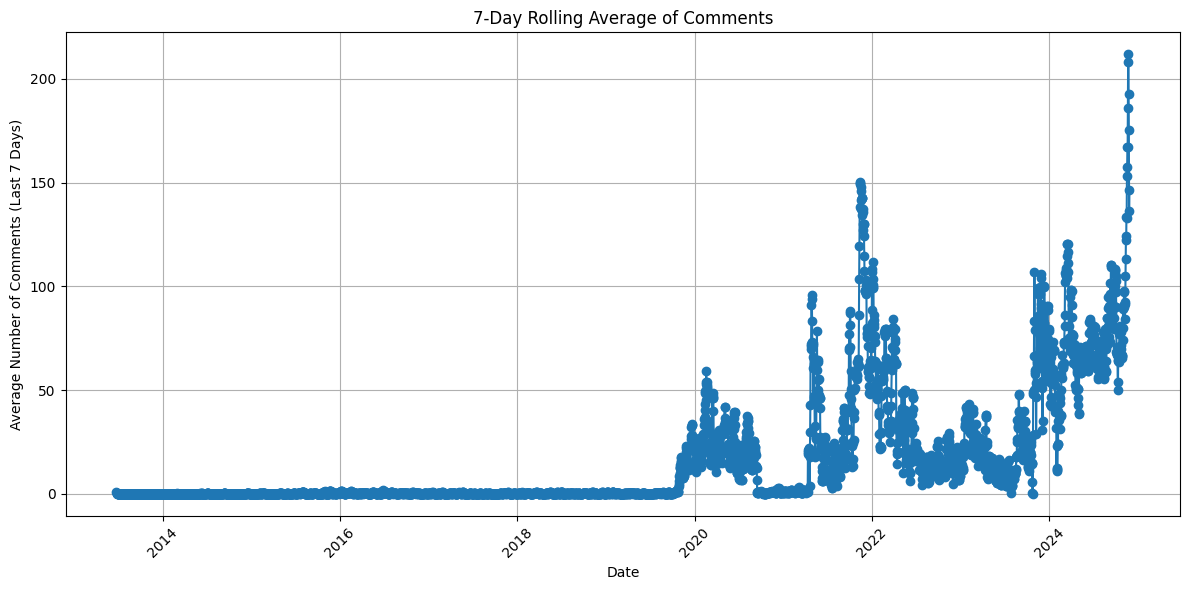

In [14]:

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('comments_data/combined_data.csv')

# Step 2: Convert the 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Step 3: Extract the date (only the day) from the 'Timestamp'
df['Date'] = df['Timestamp'].dt.date

# Step 4: Group by 'Date' and count the number of comments
daily_comments = df.groupby('Date').size().reset_index(name='CommentCount')

# Step 5: Set the 'Date' column as the index
daily_comments.set_index('Date', inplace=True)

# Step 6: Fill missing dates with zero comments
all_dates = pd.date_range(start=daily_comments.index.min(), end=daily_comments.index.max(), freq='D')
daily_comments = daily_comments.reindex(all_dates, fill_value=0)

# Step 7: Calculate the rolling average of the last 7 days
daily_comments['7DayAvg'] = daily_comments['CommentCount'].rolling(window=7, min_periods=1).mean()

# Step 8: Fill missing values in the rolling average with the last valid observation (forward fill)
daily_comments['7DayAvg'] = daily_comments['7DayAvg'].fillna(method='ffill')

# Step 9: Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_comments.index, daily_comments['7DayAvg'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Average Number of Comments (Last 7 Days)')
plt.title('7-Day Rolling Average of Comments')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\matth\AppData\Local\Temp\ipykernel_20932\61908287.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_comments['CommentCount'] = daily_comments['CommentCount'].fillna(method='ffill')


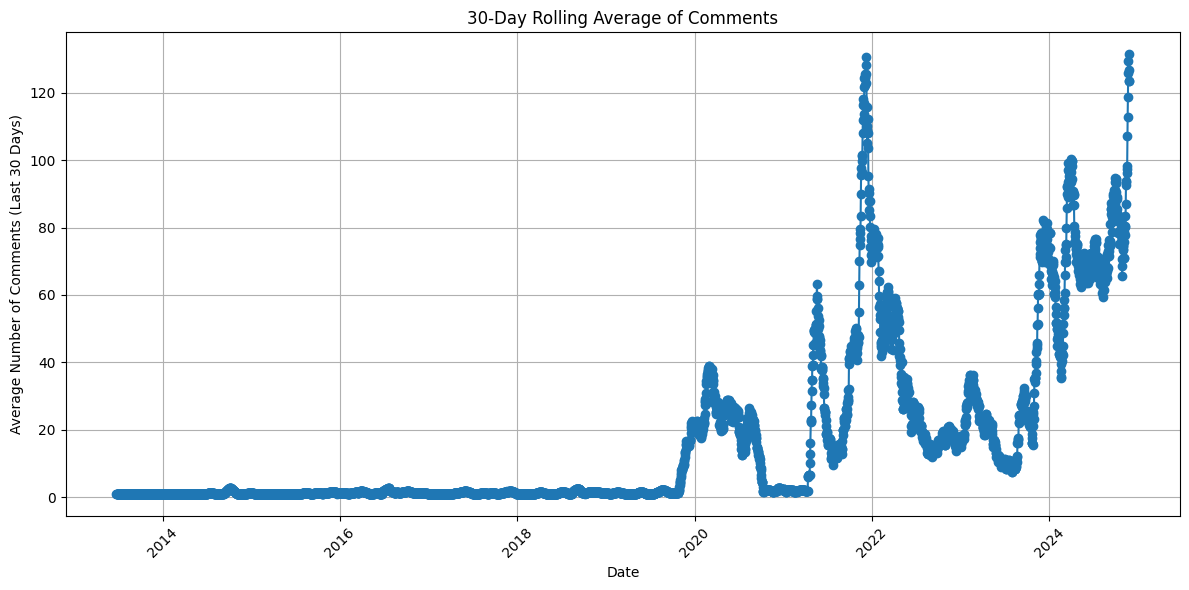

In [15]:

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('comments_data/combined_data.csv')

# Step 2: Convert the 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Step 3: Extract the date (only the day) from the 'Timestamp'
df['Date'] = df['Timestamp'].dt.date

# Step 4: Group by 'Date' and count the number of comments
daily_comments = df.groupby('Date').size().reset_index(name='CommentCount')

# Step 5: Set the 'Date' column as the index
daily_comments.set_index('Date', inplace=True)

# Step 6: Fill missing dates with the number of comments from the previous day
all_dates = pd.date_range(start=daily_comments.index.min(), end=daily_comments.index.max(), freq='D')
daily_comments = daily_comments.reindex(all_dates)
daily_comments['CommentCount'] = daily_comments['CommentCount'].fillna(method='ffill')

# Step 7: Calculate the rolling average of the last 30 days
daily_comments['30DayAvg'] = daily_comments['CommentCount'].rolling(window=30, min_periods=1).mean()

# Step 8: Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_comments.index, daily_comments['30DayAvg'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Average Number of Comments (Last 30 Days)')
plt.title('30-Day Rolling Average of Comments')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print()